# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
#распределение в таблице
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


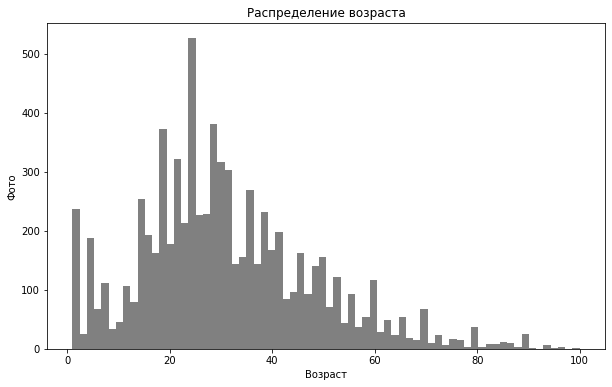

In [10]:
#график распределения
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(labels['real_age'], bins=70, color='gray')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Фото')
plt.show()

Самое большое количество фотографий для возраста от 18 до 40 лет.

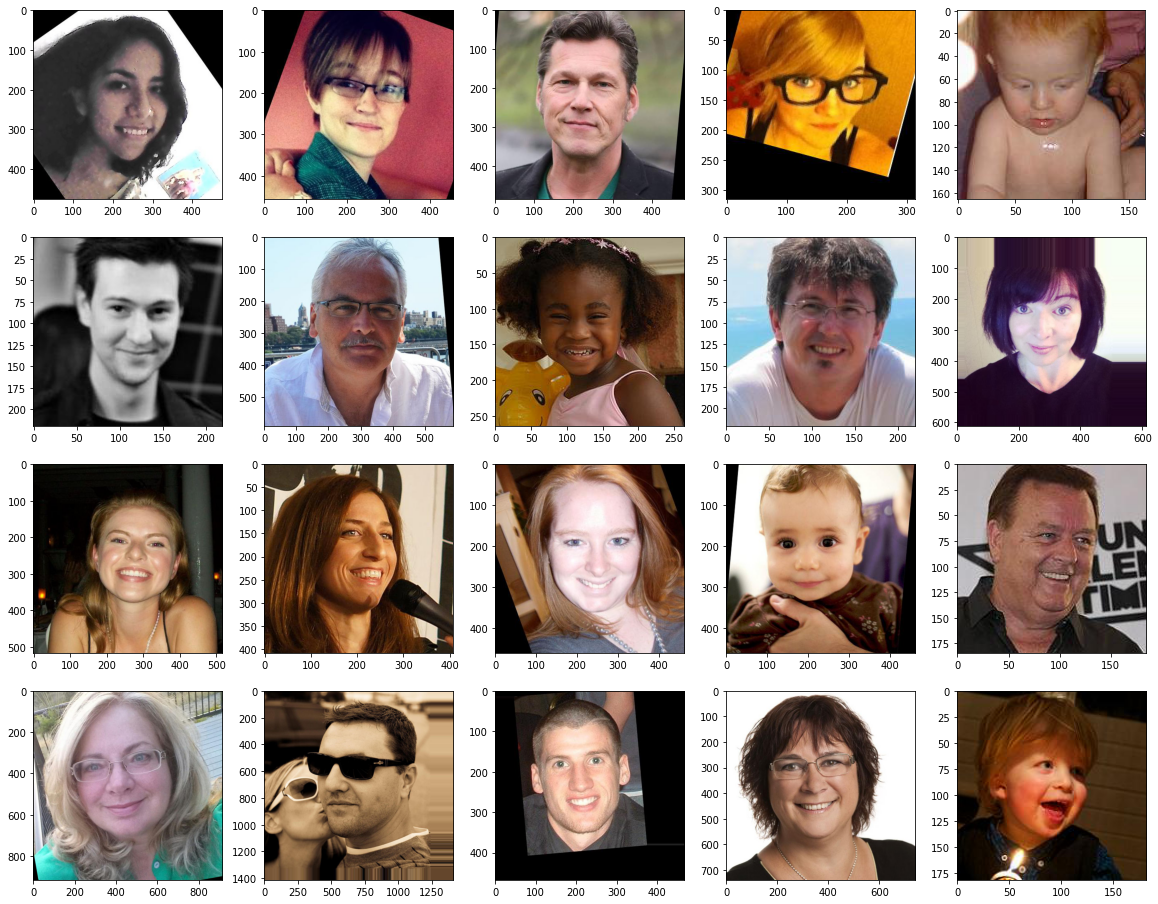

In [6]:
#посмотрим содержимое
images_dir = '/datasets/faces/final_files/'
images = os.listdir(images_dir)
sample_images = random.sample(images, k=20)
fig, ax = plt.subplots(4, 5, figsize=(20, 16)) 
for i, img_path in enumerate(sample_images):
    row = i // 5
    col = i % 5
    image = Image.open(os.path.join(images_dir, img_path))
    ax[row][col].imshow(np.array(image))
plt.show()

Поскольку не все фотографии имеют высокое разрешение и на некоторых плохо видны лица и расположены далеко, то обучение модели может быть затруднительным. Некоторые изображения смещены под разным углом, что также может затруднять процесс обучения модели. \
На графике распределения фотографий по возрасту можно наблюдать, что наибольшее количество фотографий приходится на возрастную группу от 18 до 40 лет.


# Обучение модели

In [7]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = 0.25,
        horizontal_flip = True,
        rescale = 1./255
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        seed = 12345
    )
    return train_gen_flow

In [8]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1./255
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'validation',
        seed = 12345
    )
    return test_gen_flow

In [9]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))     
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```python
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-04-24 17:11:31.853929: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-24 17:11:32.322865: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 68s - loss: 284.5637 - mae: 12.1100 - val_loss: 859.9494 - val_mae: 24.4089
Epoch 2/10
356/356 - 47s - loss: 91.6151 - mae: 7.2507 - val_loss: 166.9679 - val_mae: 9.6110
Epoch 3/10
356/356 - 51s - loss: 62.3231 - mae: 6.0273 - val_loss: 83.7518 - val_mae: 6.7456
Epoch 4/10
356/356 - 54s - loss: 48.4514 - mae: 5.2936 - val_loss: 99.8196 - val_mae: 7.8653
Epoch 5/10
356/356 - 52s - loss: 38.4072 - mae: 4.7187 - val_loss: 75.5148 - val_mae: 6.4914
Epoch 6/10
356/356 - 45s - loss: 29.4485 - mae: 4.1626 - val_loss: 76.1838 - val_mae: 6.5212
Epoch 7/10
356/356 - 43s - loss: 23.1187 - mae: 3.6820 - val_loss: 109.1699 - val_mae: 7.8576
Epoch 8/10
356/356 - 38s - loss: 17.9193 - mae: 3.2431 - val_loss: 62.5126 - val_mae: 5.8854
Epoch 9/10
356/356 - 40s - loss: 14.9438 - mae: 2.9624 - val_loss: 63.3061 - val_mae: 6.0362
Epoch 10/10
356/356 - 39s - loss: 12.9273 - mae: 2.7537 - val_loss: 66.2596 - val_mae: 5.9927
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
```

# Вывод



 Фотофиксация в прикассовой зоне может быть использована для определения возраста клиентов в целях анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы. Наша цель заключалась в достижении значения средней абсолютной ошибки MAE на тестовой выборке, которое не превышало бы 7. После обучения модели мы получили значение MAE в размере 5.9927. Модель проявила хорошие показатели, не переобучилась, так как метрика на обучающей и тестовой выборке последовательно улучшалась. Однако, необходимо учитывать, что допущенная погрешность может быть значимой при определении возраста для продажи алкоголя. В связи с этим, для более точной проверки возраста покупателей потребуется вмешательство человека, чтобы избежать ошибок и минимизировать риски для бизнеса.